In [2]:
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams.update({'figure.max_open_warning': 0})
import numpy as np
import scipy as sp
import os
import random
import matplotlib.gridspec as gridspec
import matplotlib
import matplotlib.pyplot as plt
import matplotlib
matplotlib.use( 'tkagg' )
import matplotlib.gridspec as gridspec
print(plt.style.available)
plt.style.use('seaborn-paper')
import warnings
warnings.filterwarnings('ignore')
import pickle
import tsfel
from scipy import stats
import seaborn as sns
from imblearn.over_sampling import ADASYN 
import pandas_profiling 
from FS.pso import jfs

from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
from sklearn.metrics import confusion_matrix, plot_roc_curve
from sklearn.model_selection import LeaveOneGroupOut
from sklearn.feature_selection import SelectFromModel, RFE
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import StackingClassifier
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import RandomizedSearchCV

from xgboost import XGBClassifier

from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import LSTM

%matplotlib inline

In [3]:
!pip install tsfel
!pip install statsmodels --upgrade
!pip install scipy

## Reading the Dataset 

In [28]:
def df_import(ID, file_name, date_time_start, date_time_end):
    path = '../data/' + ID + '/' + file_name
    df = pd.read_csv(path, delimiter=None, header='infer')
    df['local'] = pd.to_datetime(df['local'])
    df_sub = df[(df['local'] > date_time_start) & (df['local'] < date_time_end)].reset_index(drop=True)
    df['ID'] = ID
    df_sub['ID'] = ID 
    return df_sub

In [37]:
IDs = ['PID008', 'PID009', 'PID010','PID011','PID012','PID013', 'PID014',
       'PID015','PID016','PID017','PID018','PID019', 'PID020', 'PID021', 
       'PID022', 'PID023', 'PID024', 'PID025', 'PID026', 'PID027', 'PID028']

sensor_name = ['back.csv']

date_time_start = '2021-09-03 09:00:00'
date_time_end = '2021-09-08 15:00:00'

df_back = []

for patient in IDs:
    df_sub_back = df_import(patient, sensor_name[0], date_time_start, date_time_end)
    df_back.append(df_sub_back)
    
df_all_back = pd.concat(df_back)
df_all_back.dropna(subset = ['label'], inplace=True)
df_all_back = df_all_back.reset_index(drop=True)

## Save and import the data from a CSV file

In [6]:
df_all_back = pd.read_csv('../data/df_all_back.csv', delimiter=None, header='infer')

In [7]:
df_all_back

,utc,local,unixts,x,y,z,label,ID
0,2021-09-03T07:36:38.794000Z,2021-09-03 09:36:38.794000+02:00,1.630000e+12,0.240,0.992,-0.080,1.0,PID008
1,2021-09-03T07:37:07.659000Z,2021-09-03 09:37:07.659000+02:00,1.630000e+12,0.152,1.008,-0.136,1.0,PID008
2,2021-09-03T07:37:07.564000Z,2021-09-03 09:37:07.564000+02:00,1.630000e+12,0.152,1.008,-0.136,1.0,PID008
3,2021-09-03T07:37:07.470000Z,2021-09-03 09:37:07.470000+02:00,1.630000e+12,0.152,1.008,-0.136,1.0,PID008
4,2021-09-03T07:37:07.376000Z,2021-09-03 09:37:07.376000+02:00,1.630000e+12,0.152,1.008,-0.136,1.0,PID008
...,...,...,...,...,...,...,...,...
96718,2021-09-08T11:31:18.707000Z,2021-09-08 13:31:18.707000+02:00,1.631100e+12,1.136,-0.216,-0.216,5.0,PID028
96719,2021-09-08T11:31:18.626000Z,2021-09-08 13:31:18.626000+02:00,1.631100e+12,1.352,-0.064,-0.008,5.0,PID028
96720,2021-09-08T11:31:19.188000Z,2021-09-08 13:31:19.188000+02:00,1.631100e+12,1.056,-0.784,-0.472,5.0,PID028
96721,2021-09-08T11:32:25.923000Z,2021-09-08 13:32:25.923000+02:00,1.631100e+12,1.040,-0.104,-0.096,5.0,PID028


<AxesSubplot:>

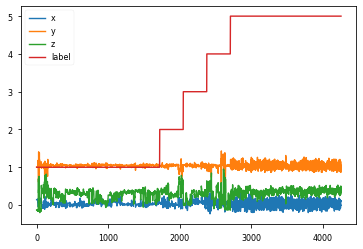

In [52]:
df_plotting = df_all_back[df_all_back['ID']=='PID018'].reset_index(drop=True)
df_plotting.iloc[:, 3:7].plot()

## Subject specific train-test split

In [8]:
IDs = ['PID008', 'PID009', 'PID010','PID011','PID012','PID013', 'PID014',
       'PID015','PID016','PID017','PID018','PID019', 'PID020', 'PID021', 
       'PID022', 'PID023', 'PID024', 'PID025', 'PID026', 'PID027', 'PID028']

random.seed(41)
train_subjects = random.sample(IDs, 16)
test_subjects = [x for x in IDs if x not in train_subjects]

df_train = df_all_back[df_all_back['ID'].isin(train_subjects)].reset_index(drop=True)
df_test = df_all_back[df_all_back['ID'].isin(test_subjects)].reset_index(drop=True)

print('Train shape: {}'.format(df_train.shape))
print('Test shape: {}'.format(df_test.shape))
print()
print('Train subjects: {}'.format(df_train.loc[:, 'ID'].unique()))
print()
print('Test subjects: {}'.format(df_test.loc[:, 'ID'].unique()))

Train shape: (75283, 8)
Test shape: (21440, 8)

Train subjects: ['PID008' 'PID009' 'PID011' 'PID012' 'PID013' 'PID014' 'PID015' 'PID016'
 'PID017' 'PID018' 'PID019' 'PID020' 'PID022' 'PID023' 'PID027' 'PID028']

Test subjects: ['PID010' 'PID024' 'PID025' 'PID026']


## Convert to a binary classification (walking vs others)

In [9]:
df_train['label'] = df_train['label'].replace([1.0, 2.0, 3.0, 4.0], 1.0)
df_train['label'] = df_train['label'].replace([5.0], 2.0)
df_test['label'] = df_test['label'].replace([1.0, 2.0, 3.0, 4.0], 1.0)
df_test['label'] = df_test['label'].replace([5.0], 2.0)

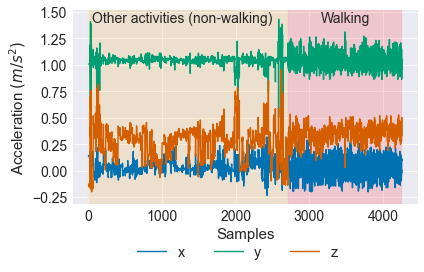

In [145]:
df_plotting = df_train[df_train['ID']=='PID018'].reset_index(drop=True)
fig_df = df_plotting.iloc[:, 3:6].plot(fontsize=14)
fig_df.set_ylabel('Acceleration $(m/s^2)$', fontdict={'fontsize': 15})
fig_df.set_xlabel('Samples', fontdict={'fontsize': 15})
fig_df.axvspan(2710, 4258, color='red', alpha=0.15)
fig_df.axvspan(0, 2709, color='orange', alpha=0.15)
fig_df.legend(fontsize='x-large', loc='lower left', bbox_to_anchor=(0.15, -0.35), ncol=3)
fig_df.text(50, 1.4, r'Other activities (non-walking)', fontdict={'weight': 'normal','size': 14})
fig_df.text(3150, 1.4, r'Walking', fontdict={'weight': 'normal','size': 14})
fig_df.figure.tight_layout()
fig_df.figure.savefig('data_example.pdf')


## Data pre-processing (scaling, sliding window, etc.)

In [10]:
x_train = df_train[['x', 'y', 'z']].values
x_test = df_test[['x', 'y', 'z']].values

In [11]:
def sliding_window(a, w, o, copy):
    sh = (a.size - w + 1, w)
    
    st = a.strides * 2
    view = np.lib.stride_tricks.as_strided(a, strides = st, shape = sh)[0::o]
    if copy:
        return view.copy()
    else:
        return view

In [17]:
w = 50 
o = 10
xAxis_win_tr = sliding_window(df_train['x'].to_numpy(), w, o, copy = True)
yAxis_win_tr = sliding_window(df_train['y'].to_numpy(), w, o, copy = True)
zAxis_win_tr = sliding_window(df_train['z'].to_numpy(), w, o, copy = True)

xAxis_win_ts = sliding_window(df_test['x'].to_numpy(), w, o, copy = True)
yAxis_win_ts = sliding_window(df_test['y'].to_numpy(), w, o, copy = True)
zAxis_win_ts = sliding_window(df_test['z'].to_numpy(), w, o, copy = True)

y_win_tr = sp.stats.mode(sliding_window(df_train['label'].to_numpy(), w, o, copy = True), axis=1)[0].ravel()
y_win_ts = sp.stats.mode(sliding_window(df_test['label'].to_numpy(), w, o, copy = True), axis=1)[0].ravel()

xy_stack_tr = np.dstack((xAxis_win_tr, yAxis_win_tr))
xyzAxis_win_tr = np.dstack((xy_stack_tr, zAxis_win_tr))

xy_stack_ts = np.dstack((xAxis_win_ts, yAxis_win_ts))
xyzAxis_win_ts = np.dstack((xy_stack_ts, zAxis_win_ts))

In [25]:
cfg = tsfel.get_features_by_domain()

feat_test = tsfel.time_series_features_extractor(cfg, xAxis_win_tr[0:10], fs=11)

*** Feature extraction started ***



*** Feature extraction finished ***


## ML model

### Feature extraction usin TSFEL package

In [ ]:
cfg = tsfel.get_features_by_domain()

feat_x_tr = tsfel.time_series_features_extractor(cfg, xyzAxis_win_tr[:,:,0], fs=11)
feat_y_tr = tsfel.time_series_features_extractor(cfg, xyzAxis_win_tr[:,:,1], fs=11)
feat_z_tr = tsfel.time_series_features_extractor(cfg, xyzAxis_win_tr[:,:,2], fs=11)

feat_x_ts = tsfel.time_series_features_extractor(cfg, xyzAxis_win_ts[:,:,0], fs=11)
feat_y_ts = tsfel.time_series_features_extractor(cfg, xyzAxis_win_ts[:,:,1], fs=11)
feat_z_ts = tsfel.time_series_features_extractor(cfg, xyzAxis_win_ts[:,:,2], fs=11)

*** Feature extraction started ***


In [104]:
xyzAxis_win_tr = feat_x_tr.values.T
xyzAxis_win_ts = feat_x_ts.values.T

### Manual feature extraction 

In [126]:
def shannon_entr(arr):
    temp = []
    for i in range(arr.shape[0]):
        pA = arr[i] / arr[i].sum()
        Shannon = -np.sum(pA*np.log2(pA))
        temp.append(Shannon)
        
    return temp


def mad(data, axis=None, scale=1.4826, keepdims=False):
    """Median absolute deviation (MAD).
    
    Defined as the median absolute deviation from the median of the data. A
    robust alternative to stddev. Results should be identical to
    scipy.stats.median_absolute_deviation(), which does not take a keepdims
    argument.

    Parameters
    ----------
    data : array_like
        The data.
    scale : float, optional
        Scaling of the result. By default, it is scaled to give a consistent
        estimate of the standard deviation of values from a normal
        distribution.
    axis : numpy axis spec, optional
        Axis or axes along which to compute MAD.
    keepdims : bool, optional
        If this is set to True, the axes which are reduced are left in the
        result as dimensions with size one.

    Returns
    -------
    ndarray
        The MAD.
    """
    # keep dims here so that broadcasting works
    med = np.median(data, axis=axis, keepdims=True)
    abs_devs = np.abs(data - med)
    return scale * np.median(abs_devs, axis=axis, keepdims=keepdims)
    
    
mean_win_x_tr = np.mean(xAxis_win_tr, axis=1)
mean_win_y_tr = np.mean(yAxis_win_tr, axis=1)
mean_win_z_tr = np.mean(zAxis_win_tr, axis=1)

std_win_x_tr = np.std(xAxis_win_tr, axis=1)
std_win_y_tr = np.std(yAxis_win_tr, axis=1)
std_win_z_tr = np.std(zAxis_win_tr, axis=1)

mean_win_x_ts = np.mean(xAxis_win_ts, axis=1)
mean_win_y_ts = np.mean(yAxis_win_ts, axis=1)
mean_win_z_ts = np.mean(zAxis_win_ts, axis=1)

std_win_x_ts = np.std(xAxis_win_ts, axis=1)
std_win_y_ts = np.std(yAxis_win_ts, axis=1)
std_win_z_ts = np.std(zAxis_win_ts, axis=1)

max_std_xyz_tr = np.max(np.stack([std_win_x_tr, std_win_y_tr, std_win_z_tr]), axis=0)
max_std_xyz_ts = np.max(np.stack([std_win_x_ts, std_win_y_ts, std_win_z_ts]), axis=0)

shann_x_tr = np.nan_to_num(np.array(shannon_entr(xAxis_win_tr)))
shann_y_tr = np.nan_to_num(np.array(shannon_entr(yAxis_win_tr)))
shann_z_tr = np.nan_to_num(np.array(shannon_entr(zAxis_win_tr)))

shann_x_ts = np.nan_to_num(np.array(shannon_entr(xAxis_win_ts)))
shann_y_ts = np.nan_to_num(np.array(shannon_entr(xAxis_win_ts)))
shann_z_ts = np.nan_to_num(np.array(shannon_entr(xAxis_win_ts)))

energy_x_tr = np.sum(xAxis_win_tr**2, axis=1)/xAxis_win_tr.shape[1]
energy_y_tr = np.sum(yAxis_win_tr**2, axis=1)/yAxis_win_tr.shape[1]
energy_z_tr = np.sum(zAxis_win_tr**2, axis=1)/zAxis_win_tr.shape[1]

energy_x_ts = np.sum(xAxis_win_ts**2, axis=1)/xAxis_win_ts.shape[1]
energy_y_ts = np.sum(yAxis_win_ts**2, axis=1)/yAxis_win_ts.shape[1]
energy_z_ts = np.sum(zAxis_win_ts**2, axis=1)/zAxis_win_ts.shape[1]

mad_x_tr = mad(xAxis_win_tr, axis=1, scale=1.4826, keepdims=False)
mad_y_tr = mad(yAxis_win_tr, axis=1, scale=1.4826, keepdims=False)
mad_z_tr = mad(zAxis_win_tr, axis=1, scale=1.4826, keepdims=False)

mad_x_ts = mad(xAxis_win_ts, axis=1, scale=1.4826, keepdims=False)
mad_y_ts = mad(yAxis_win_ts, axis=1, scale=1.4826, keepdims=False)
mad_z_ts = mad(zAxis_win_ts, axis=1, scale=1.4826, keepdims=False)




<ipython-input-126-65c2e0fc9c9c>:5: RuntimeWarning: invalid value encountered in log2
  Shannon = -np.sum(pA*np.log2(pA))
<ipython-input-126-65c2e0fc9c9c>:5: RuntimeWarning: divide by zero encountered in log2
  Shannon = -np.sum(pA*np.log2(pA))
<ipython-input-126-65c2e0fc9c9c>:5: RuntimeWarning: invalid value encountered in multiply
  Shannon = -np.sum(pA*np.log2(pA))
<ipython-input-126-65c2e0fc9c9c>:4: RuntimeWarning: invalid value encountered in true_divide
  pA = arr[i] / arr[i].sum()
<ipython-input-126-65c2e0fc9c9c>:4: RuntimeWarning: divide by zero encountered in true_divide
  pA = arr[i] / arr[i].sum()


In [127]:
xyzAxis_win_tr = np.stack([mean_win_x_tr, mean_win_y_tr, mean_win_z_tr,
                           std_win_x_tr, std_win_y_tr, std_win_z_tr, 
                           max_std_xyz_tr, 
                           shann_x_tr, shann_y_tr, shann_z_tr,
                          energy_x_tr, energy_y_tr, energy_z_tr,
                         mad_x_tr, mad_y_tr, mad_z_tr])

xyzAxis_win_ts = np.stack([mean_win_x_ts, mean_win_y_ts, mean_win_z_ts, 
                           std_win_x_ts, std_win_y_ts, std_win_z_ts, 
                           max_std_xyz_ts, 
                           shann_x_ts, shann_y_ts, shann_z_ts,
                          energy_x_ts, energy_y_ts, energy_z_ts,
                          mad_x_ts, mad_y_ts, mad_z_ts])


## Intra-patient analysis (leave one group out CV) 

In [11]:
df_all_back = pd.read_csv('../data/df_all_back.csv', delimiter=None, header='infer')

df_all_back[df_all_back['ID'].isin(['PID008','PID009'])]
step=0

logo = LeaveOneGroupOut()
ids = df_all_back.loc[:, 'ID']
logo.get_n_splits(groups=ids)

df_all_back['label'] = df_all_back['label'].replace([1.0, 2.0, 3.0, 4.0], 1.0)
df_all_back['label'] = df_all_back['label'].replace([5.0], 2.0)

X = df_all_back.loc[:, ['x', 'y', 'z']].values
y = df_all_back.loc[:, 'label'].values - 1

ada = ADASYN(random_state=42)

w = 66 #50
o = 33 #25

preds_all = []
proba_all = []
y_ts_win_all = []
acc_all = []
fmdl_all = []

cfg = tsfel.get_features_by_domain()

for train_index, test_index in logo.split(X, y, ids):
    
    if step!=2:
    
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        X_train_res, y_train_res = ada.fit_resample(X_train, y_train)

        x_tr_win = sliding_window(X_train_res.T[0,:], w, o, copy = True)
        y_tr_win = sliding_window(X_train_res.T[1,:], w, o, copy = True)
        z_tr_win = sliding_window(X_train_res.T[2,:], w, o, copy = True)

        x_ts_win = sliding_window(X_test.T[0,:], w, o, copy = True)
        y_ts_win = sliding_window(X_test.T[1,:], w, o, copy = True)
        z_ts_win = sliding_window(X_test.T[2,:], w, o, copy = True)

        label_tr_win = sp.stats.mode(sliding_window(y_train_res, w, o, copy = True), axis=1)[0].ravel()
        label_ts_win = sp.stats.mode(sliding_window(y_test, w, o, copy = True), axis=1)[0].ravel()

        feat_x_tr = tsfel.time_series_features_extractor(cfg, x_tr_win, fs=11, verbose=0)
        feat_y_tr = tsfel.time_series_features_extractor(cfg, y_tr_win, fs=11, verbose=0)
        feat_z_tr = tsfel.time_series_features_extractor(cfg, z_tr_win, fs=11, verbose=0)

        feat_xyz_tr = pd.concat([feat_x_tr, feat_y_tr, feat_z_tr], axis=1)

        feat_x_ts = tsfel.time_series_features_extractor(cfg, x_ts_win, fs=11, verbose=0)
        feat_y_ts = tsfel.time_series_features_extractor(cfg, y_ts_win, fs=11, verbose=0)
        feat_z_ts = tsfel.time_series_features_extractor(cfg, z_ts_win, fs=11, verbose=0)

        feat_xyz_ts = pd.concat([feat_x_ts, feat_y_ts, feat_z_ts], axis=1)



        # parameter
        k = 5     # k-value in KNN
        N = 10    # number of particles
        T = 100   # maximum number of iterations
        fold = {'xt':feat_xyz_tr.values, 'yt':label_tr_win, 'xv':feat_xyz_ts.values, 'yv':label_ts_win}
        opts = {'k':k, 'fold':fold, 'N':N, 'T':T}

        # perform feature selection
        fmdl = jfs(feat_xyz_tr.values, label_tr_win, opts)
        sf = fmdl['sf']

        # model with selected features
        num_train = np.size(feat_xyz_tr.values, 0)
        num_valid = np.size(feat_xyz_ts.values, 0)
        xtrain = feat_xyz_tr.values[:, sf]
        ytrain = label_tr_win.reshape(num_train)  # Solve bug
        xtest = feat_xyz_ts.values[:, sf]
        ytest = label_ts_win.reshape(num_valid)  # Solve bug

        distributions = dict(n_neighbors=[3, 5, 7, 10])
        search = RandomizedSearchCV(KNeighborsClassifier(), distributions, random_state=0)
        search.fit(xtrain, ytrain)
        model = KNeighborsClassifier(n_neighbors = search.best_params_['n_neighbors'])
        model.fit(xtrain, ytrain)

        # number of selected features
        num_feat = fmdl['nf']
        print("Feature Size:", num_feat)

        fmdl_all.append(fmdl)

        y_pred_ts = model.predict(xtest)
        y_proba_ts = model.predict_proba(xtest)

        preds_all.append(y_pred_ts)
        proba_all.append(y_proba_ts)
        y_ts_win_all.append(ytest)

        print('The performance on the {}:'.format(df_all_back.loc[test_index[0], 'ID']))
        print()
        acc = accuracy_score(ytest, y_pred_ts)
        print("ACCURACY OF THE MODEL: ", acc)
        print()
        print(classification_report(ytest, y_pred_ts, target_names=['other activities', 'walking']))

        acc_all.append(acc) 

        step+=1

preds_all = np.array(preds_all)
proba_all = np.array(proba_all)
y_ts_win_all = np.array(y_ts_win_all)


with open('../saved_results/pred_all_50_25.npy', 'wb') as f:
    np.save(f, np.array(preds_all))
    
with open('../saved_results/proba_all_50_25.npy', 'wb') as f:
    np.save(f, np.array(proba_all))
    
with open('../saved_results/y_ts_win_all_50_25.npy', 'wb') as f:
    np.save(f, np.array(y_ts_win_all))
    
with open('../saved_results/acc_all_50_25.npy', 'wb') as f:
    np.save(f, np.array(acc_all))
    
with open('../saved_results/fmdl_all_50_25.npy', 'wb') as f:
    np.save(f, np.array(fmdl_all))
    


Feature Size: 200
The performance on the PID008:

ACCURACY OF THE MODEL:  1.0

                  precision    recall  f1-score   support

other activities       1.00      1.00      1.00        93
         walking       1.00      1.00      1.00        12

        accuracy                           1.00       105
       macro avg       1.00      1.00      1.00       105
    weighted avg       1.00      1.00      1.00       105



Feature Size: 217
The performance on the PID009:

ACCURACY OF THE MODEL:  0.9691358024691358

                  precision    recall  f1-score   support

other activities       1.00      0.96      0.98       141
         walking       0.81      1.00      0.89        21

        accuracy                           0.97       162
       macro avg       0.90      0.98      0.94       162
    weighted avg       0.98      0.97      0.97       162



## Plotting

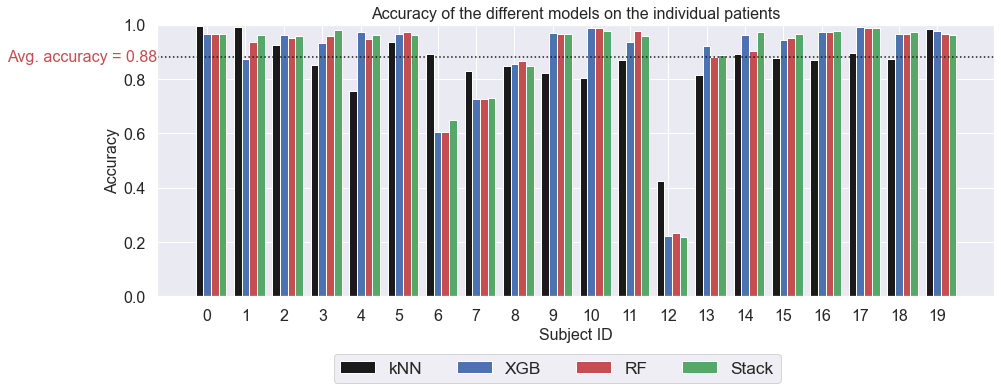

Avg. accuracy of kNN: 85.75
Avg. accuracy of Random Forest: 88.53
Avg. accuracy of XGBoost: 88.47
Avg. accuracy of Stacked Classifier: 89.22


<Figure size 432x288 with 0 Axes>

In [10]:
preds_all_rf = np.load('../saved_results/pred_all_rf_50_25.npy', allow_pickle=True)
y_ts_win_all_rf = np.load('../saved_results/y_ts_win_all_rf_50_25.npy', allow_pickle=True)
preds_all_knn = np.load('../saved_results/pred_all_knn_50_25.npy', allow_pickle=True)
y_ts_win_all_knn = np.load('../saved_results/y_ts_win_all_knn_50_25.npy', allow_pickle=True)
preds_all_xgb = np.load('../saved_results/pred_all_xgb_50_25.npy', allow_pickle=True)
y_ts_win_all_xgb = np.load('../saved_results/y_ts_win_all_xgb_50_25.npy', allow_pickle=True)
preds_all_stack = np.load('../saved_results/pred_all_stack_50_25.npy', allow_pickle=True)
y_ts_win_all_stack = np.load('../saved_results/y_ts_win_all_stack_50_25.npy', allow_pickle=True)

def accuracy_all(y_ts_win_all, preds_all):
    acc_all = []
    for i in range(len(preds_all)):
        acc = accuracy_score(y_ts_win_all[i], preds_all[i])
        acc_all.append(acc)
    return acc_all
    
acc_all_knn = accuracy_all(y_ts_win_all_knn, preds_all_knn)
acc_all_rf = accuracy_all(y_ts_win_all_rf, preds_all_rf)
acc_all_xgb = accuracy_all(y_ts_win_all_xgb, preds_all_xgb)
acc_all_stack = accuracy_all(y_ts_win_all_stack, preds_all_stack)

X_axis = np.arange(len(list(df_all_back['ID'].unique())))
  
fig = plt.figure(figsize = (15, 5))

multiple_lists = [acc_all_knn, acc_all_rf, acc_all_xgb, acc_all_stack]
arrays = [np.array(x) for x in multiple_lists]
average_acc = [np.mean(k) for k in zip(*arrays)]
sum(average_acc)/len(average_acc)

plt.bar(X_axis - 0.2, np.array(acc_all_knn), width = 0.2, label = 'kNN', color='k')#, hatch=["/"]
plt.bar(X_axis , acc_all_xgb, width = 0.2, label = 'XGB')#, hatch=["\\"]
plt.bar(X_axis + 0.2, acc_all_rf, width = 0.2, label = 'RF', color='r')#, hatch=["-"]
plt.bar(X_axis + 0.4, acc_all_stack, width = 0.2, label = 'Stack', color='g')

plt.axhline(y=0.88, color='k', linestyle=':')
plt.text(-5.2, 0.88, 'Avg. accuracy = 0.88', verticalalignment='center', fontdict={'fontsize': 16}, color='r')

plt.ylim([0, 1.0])
plt.xlabel("Subject ID", fontdict={'fontsize': 16})
plt.xticks(X_axis, list(df_all_back['ID'].unique()).remove('PID012'))
plt.xticks(rotation=0, fontsize=16)
plt.yticks(fontsize=16)
plt.ylabel("Accuracy", fontdict={'fontsize': 16})
plt.title("Accuracy of the different models on the individual patients", fontdict={'fontsize': 16})
plt.legend(fontsize='x-large', loc='lower left', bbox_to_anchor=(0.2, -0.35), ncol=4)
plt.show()         
plt.savefig("acc.png")

print('Avg. accuracy of kNN: {:.2f}'.format(sum(acc_all_knn)/len(acc_all_knn)*100))
print('Avg. accuracy of Random Forest: {:.2f}'.format(sum(acc_all_rf)/len(acc_all_rf)*100))
print('Avg. accuracy of XGBoost: {:.2f}'.format(sum(acc_all_xgb)/len(acc_all_xgb)*100))
print('Avg. accuracy of Stacked Classifier: {:.2f}'.format(sum(acc_all_stack)/len(acc_all_stack)*100))

sns.set(font_scale=1)

<AxesSubplot:>

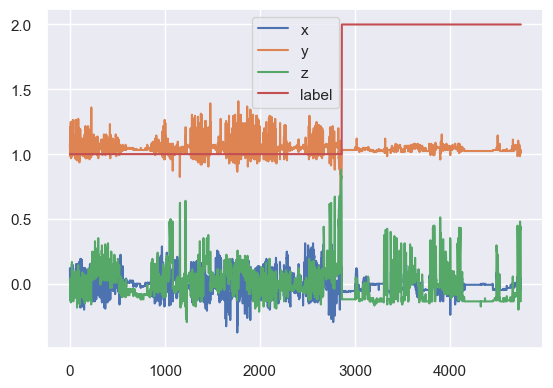

In [277]:
df_021 = df_all_back[df_all_back['ID'] == 'PID021'].reset_index(drop=True)
df_021.loc[:, ['x', 'y', 'z', 'label']].plot()

In [1]:
def metrics(activity, metric, y_ts_win_all, preds_all):
    perf_all = []
    for i in range(len(preds_all)):
        perf = classification_report(y_ts_win_all[i], preds_all[i], 
                                     output_dict=True, target_names=['other activities', 'walking'])
        perf_all.append(perf[activity][metric]) 
    return perf_all


activity = 'macro avg'
metric = 'recall'
perf_all_knn = metrics(activity, metric, y_ts_win_all_knn, preds_all_knn)
perf_all_rf = metrics(activity, metric, y_ts_win_all_rf, preds_all_rf)
perf_all_xgb = metrics(activity, metric, y_ts_win_all_xgb, preds_all_xgb)
perf_all_stack = metrics(activity, metric, y_ts_win_all_stack, preds_all_stack)

X_axis = np.arange(len(list(df_all_back['ID'].unique())))
        
fig = plt.figure(figsize = (15, 5))

plt.bar(X_axis - 0.2, perf_all_knn, width = 0.2, label = 'kNN', color='k')
plt.bar(X_axis, perf_all_xgb, width = 0.2, label = 'XGB')
plt.bar(X_axis + 0.2, perf_all_rf, width = 0.2, label = 'RF', color='r')
plt.bar(X_axis + 0.4, perf_all_stack, width = 0.2, label = 'Stack', color='g')

plt.xlabel("Subject ID", fontdict={'fontsize': 16})
plt.xticks(X_axis, list(df_all_back['ID'].unique()).remove('PID012'))
plt.xticks(rotation=0, fontsize=16)
plt.yticks(fontsize=16)
plt.ylabel(metric, fontdict={'fontsize': 16})
plt.title("Performance of the model on the individual patients", fontdict={'fontsize': 16})
plt.legend(fontsize='x-large', loc='lower left', bbox_to_anchor=(0.2, -0.35), ncol=4)
plt.show() 
plt.savefig("recall.png")

print('Avg. recall/sensitivity of kNN: {:.2f}'.format(sum(perf_all_knn)/len(perf_all_knn)*100))
print('Avg. recall/sensitivity of Random Forest: {:.2f}'.format(sum(perf_all_rf)/len(perf_all_rf)*100))
print('Avg. recall/sensitivity of XGBoost: {:.2f}'.format(sum(perf_all_xgb)/len(perf_all_xgb)*100))
print('Avg. recall/sensitivity of Stacked Classifier: {:.2f}'.format(sum(perf_all_stack)/len(perf_all_stack)*100))


activity = 'macro avg'
metric = 'precision'
perf_all_knn = metrics(activity, metric, y_ts_win_all_knn, preds_all_knn)
perf_all_rf = metrics(activity, metric, y_ts_win_all_rf, preds_all_rf)
perf_all_xgb = metrics(activity, metric, y_ts_win_all_xgb, preds_all_xgb)
perf_all_stack = metrics(activity, metric, y_ts_win_all_stack, preds_all_stack)

        
fig = plt.figure(figsize = (15, 5))

plt.bar(X_axis - 0.2, perf_all_knn, width = 0.2, label = 'kNN', color='k')
plt.bar(X_axis, perf_all_xgb, width = 0.2, label = 'XGB')
plt.bar(X_axis + 0.2, perf_all_rf, width = 0.2, label = 'RF', color='r')
plt.bar(X_axis + 0.4, perf_all_stack, width = 0.2, label = 'Stack', color='g')

plt.xlabel("Subject ID", fontdict={'fontsize': 16})
plt.xticks(X_axis, list(df_all_back['ID'].unique()).remove('PID012'))
plt.xticks(rotation=0, fontsize=16)
plt.yticks(fontsize=16)
plt.ylabel(metric, fontdict={'fontsize': 16})
plt.title("Performance of the model on the individual patients", fontdict={'fontsize': 16})
plt.legend(fontsize='x-large', loc='lower left', bbox_to_anchor=(0.2, -0.35), ncol=4)
plt.show() 
plt.savefig("precision.png")

print('Avg. precision of kNN: {:.2f}'.format(sum(perf_all_knn)/len(perf_all_knn)*100))
print('Avg. precision of Random Forest: {:.2f}'.format(sum(perf_all_rf)/len(perf_all_rf)*100))
print('Avg. precision of XGBoost: {:.2f}'.format(sum(perf_all_xgb)/len(perf_all_xgb)*100))
print('Avg. precision of Stacked Classifier: {:.2f}'.format(sum(perf_all_stack)/len(perf_all_stack)*100))


## Inter-patient analysis

In [288]:
df_all_back = pd.read_csv('../data/df_all_back.csv', delimiter=None, header='infer')

df_all_back['label'] = df_all_back['label'].replace([1.0, 2.0, 3.0, 4.0], 1.0)
df_all_back['label'] = df_all_back['label'].replace([5.0], 2.0)

IDs = ['PID008', 'PID009', 'PID010','PID011','PID012','PID013', 'PID014',
       'PID015','PID016','PID017','PID018','PID019', 'PID020', 'PID021', 
       'PID022', 'PID023', 'PID024', 'PID025', 'PID026', 'PID027', 'PID028']

test_subjects = ['PID010', 'PID023', 'PID016', 'PID020', 'PID028']
train_subjects = [x for x in IDs if x not in test_subjects]

df_train = df_all_back[df_all_back['ID'].isin(train_subjects)].reset_index(drop=True)
df_test = df_all_back[df_all_back['ID'].isin(test_subjects)].reset_index(drop=True)

print('Train shape: {}'.format(df_train.shape))
print('Test shape: {}'.format(df_test.shape))
print()
print('Train subjects: {}'.format(df_train.loc[:, 'ID'].unique()))
print()
print('Test subjects: {}'.format(df_test.loc[:, 'ID'].unique()))


X_train = df_train[['x', 'y', 'z']].values
X_test = df_test[['x', 'y', 'z']].values
y_train = df_train['label'].values - 1
y_test = df_test['label'].values - 1


def sliding_window(a, w, o, copy):
    sh = (a.size - w + 1, w)
    
    st = a.strides * 2
    view = np.lib.stride_tricks.as_strided(a, strides = st, shape = sh)[0::o]
    if copy:
        return view.copy()
    else:
        return view

    
ada = ADASYN(random_state=42)
cfg = tsfel.get_features_by_domain()

w = 66 #50
o = 33 #25

X_train_res, y_train_res = ada.fit_resample(X_train, y_train)

x_tr_win = sliding_window(X_train_res.T[0,:], w, o, copy = True)
y_tr_win = sliding_window(X_train_res.T[1,:], w, o, copy = True)
z_tr_win = sliding_window(X_train_res.T[2,:], w, o, copy = True)

x_ts_win = sliding_window(X_test.T[0,:], w, o, copy = True)
y_ts_win = sliding_window(X_test.T[1,:], w, o, copy = True)
z_ts_win = sliding_window(X_test.T[2,:], w, o, copy = True)

label_tr_win = sp.stats.mode(sliding_window(y_train_res, w, o, copy = True), axis=1)[0].ravel()
label_ts_win = sp.stats.mode(sliding_window(y_test, w, o, copy = True), axis=1)[0].ravel()

feat_x_tr = tsfel.time_series_features_extractor(cfg, x_tr_win, fs=11, verbose=0)
feat_y_tr = tsfel.time_series_features_extractor(cfg, y_tr_win, fs=11, verbose=0)
feat_z_tr = tsfel.time_series_features_extractor(cfg, z_tr_win, fs=11, verbose=0)

feat_xyz_tr = pd.concat([feat_x_tr, feat_y_tr, feat_z_tr], axis=1)

feat_x_ts = tsfel.time_series_features_extractor(cfg, x_ts_win, fs=11, verbose=0)
feat_y_ts = tsfel.time_series_features_extractor(cfg, y_ts_win, fs=11, verbose=0)
feat_z_ts = tsfel.time_series_features_extractor(cfg, z_ts_win, fs=11, verbose=0)

feat_xyz_ts = pd.concat([feat_x_ts, feat_y_ts, feat_z_ts], axis=1)

# parameter
k = 5     # k-value in KNN
N = 10    # number of particles
T = 100   # maximum number of iterations
fold = {'xt':feat_xyz_tr.values, 'yt':label_tr_win, 'xv':feat_xyz_ts.values, 'yv':label_ts_win}
opts = {'k':k, 'fold':fold, 'N':N, 'T':T}

# perform feature selection
fmdl = jfs(feat_xyz_tr.values, label_tr_win, opts)
sf = fmdl['sf']

# model with selected features
num_train = np.size(feat_xyz_tr.values, 0)
num_valid = np.size(feat_xyz_ts.values, 0)
xtrain = feat_xyz_tr.values[:, sf]
ytrain = label_tr_win.reshape(num_train)  # Solve bug
xtest = feat_xyz_ts.values[:, sf]
ytest = label_ts_win.reshape(num_valid)  # Solve bug

## kNN
distributions = dict(n_neighbors=[3, 5, 7, 10])
search = RandomizedSearchCV(KNeighborsClassifier(), distributions, random_state=0)
search.fit(xtrain, ytrain)
model_knn = KNeighborsClassifier(n_neighbors = search.best_params_['n_neighbors'])

## Random Forest
distributions = dict(n_estimators=[50, 100, 200, 300], max_features=['auto', 'sqrt', 'log2'], max_depth=[4,5,6,7,8])
search = RandomizedSearchCV(RandomForestClassifier(), distributions, random_state=0)
search.fit(xtrain, ytrain)
model_rf = RandomForestClassifier(n_estimators=search.best_params_['n_estimators'], 
                               max_features=search.best_params_['max_features'],
                               max_depth=search.best_params_['max_depth'])

## XGBoost
distributions = dict(n_estimators=[50, 100, 200, 300], gamma=[0.5, 1, 1.5, 2, 5], max_depth=[3, 4, 5, 6, 7, 8])
search = RandomizedSearchCV(XGBClassifier(), distributions, random_state=0)
search.fit(xtrain, ytrain)
model_xgb = XGBClassifier(n_estimators=search.best_params_['n_estimators'], 
                      gamma=search.best_params_['gamma'],
                      max_depth=search.best_params_['max_depth'])

## Stacking Classifier
estimators = [
        ('rf', RandomForestClassifier(n_estimators=search.best_params_['n_estimators'], 
                                      max_depth=search.best_params_['max_depth'])),
        ('knn', KNeighborsClassifier(n_neighbors = 7)),
        ('xgb', XGBClassifier(n_estimators=search.best_params_['n_estimators'], 
                              gamma=search.best_params_['gamma'],
                              max_depth=search.best_params_['max_depth']))
]

model_stack = StackingClassifier(estimators=estimators, final_estimator=LogisticRegression())

model_knn.fit(xtrain, ytrain)
model_rf.fit(xtrain, ytrain)
model_xgb.fit(xtrain, ytrain)
model_stack.fit(xtrain, ytrain)

# number of selected features
num_feat = fmdl['nf']
print("Feature Size:", num_feat)

y_pred_ts_knn = model_knn.predict(xtest)
y_proba_ts_knn = model_knn.predict_proba(xtest)

y_pred_ts_rf = model_rf.predict(xtest)
y_proba_ts_rf = model_rf.predict_proba(xtest)

y_pred_ts_xgb = model_xgb.predict(xtest)
y_proba_ts_xgb = model_xgb.predict_proba(xtest)

y_pred_ts_stack = model_stack.predict(xtest)
y_proba_ts_stack = model_stack.predict_proba(xtest)

acc_knn = accuracy_score(ytest, y_pred_ts_knn)
print("ACCURACY OF THE KNN MODEL: ", acc_knn)
acc_rf = accuracy_score(ytest, y_pred_ts_rf)
print("ACCURACY OF THE RF MODEL: ", acc_rf)
acc_xgb = accuracy_score(ytest, y_pred_ts_xgb)
print("ACCURACY OF THE XGBoost MODEL: ", acc_xgb)
acc_stack = accuracy_score(ytest, y_pred_ts_stack)
print("ACCURACY OF THE StackingClassifier MODEL: ", acc_stack)
print()
print(classification_report(ytest, y_pred_ts_knn, target_names=['other activities', 'walking']))
print()
print(classification_report(ytest, y_pred_ts_rf, target_names=['other activities', 'walking']))
print()
print(classification_report(ytest, y_pred_ts_xgb, target_names=['other activities', 'walking']))
print()
print(classification_report(ytest, y_pred_ts_stack, target_names=['other activities', 'walking']))


with open('../saved_results/pred_knn_66_33.npy', 'wb') as f:
    np.save(f, np.array(y_pred_ts_knn))
    
with open('../saved_results/pred_rf_66_33.npy', 'wb') as f:
    np.save(f, np.array(y_pred_ts_rf))
    
with open('../saved_results/pred_xgb_66_33.npy', 'wb') as f:
    np.save(f, np.array(y_pred_ts_xgb))
    
with open('../saved_results/pred_stack_66_33.npy', 'wb') as f:
    np.save(f, np.array(y_pred_ts_stack))
    
with open('../saved_results/proba_knn_66_33.npy', 'wb') as f:
    np.save(f, np.array(y_proba_ts_knn))
    
with open('../saved_results/proba_rf_66_33.npy', 'wb') as f:
    np.save(f, np.array(y_proba_ts_rf))
    
with open('../saved_results/proba_xgb_66_33.npy', 'wb') as f:
    np.save(f, np.array(y_proba_ts_xgb))
    
with open('../saved_results/proba_stack_66_33.npy', 'wb') as f:
    np.save(f, np.array(y_proba_ts_stack))
    
with open('../saved_results/acc_knn_66_33.npy', 'wb') as f:
    np.save(f, np.array(acc_knn))
    
with open('../saved_results/acc_rf_66_33.npy', 'wb') as f:
    np.save(f, np.array(acc_rf))
    
with open('../saved_results/acc_xgb_66_33.npy', 'wb') as f:
    np.save(f, np.array(acc_xgb))
    
with open('../saved_results/acc_stack_66_33.npy', 'wb') as f:
    np.save(f, np.array(acc_stack))
    
with open('../saved_results/ytest_66_33.npy', 'wb') as f:
    np.save(f, np.array(ytest))
    
with open('../saved_results/fmdl_all_66_33.npy', 'wb') as f:
    np.save(f, np.array(fmdl))  

    
with open('model_knn.pkl', 'wb') as f:
    pickle.dump(model_knn, f)
    
with open('model_rf.pkl', 'wb') as f:
    pickle.dump(model_rf, f)
    
with open('model_xgb.pkl', 'wb') as f:
    pickle.dump(model_xgb, f)
    
with open('model_stack.pkl', 'wb') as f:
    pickle.dump(model_stack, f)
    


Train shape: (77735, 8)
Test shape: (23733, 8)

Train subjects: ['PID008' 'PID009' 'PID011' 'PID012' 'PID013' 'PID014' 'PID015' 'PID017'
 'PID018' 'PID019' 'PID021' 'PID022' 'PID024' 'PID025' 'PID026' 'PID027']

Test subjects: ['PID010' 'PID016' 'PID020' 'PID023' 'PID028']


[11:58:49] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[11:58:50] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[11:58:51] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[11:58:52] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[12:01:14] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:01:22] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:01:29] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:01:38] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[12:04:00] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:04:01] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:04:02] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:04:03] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

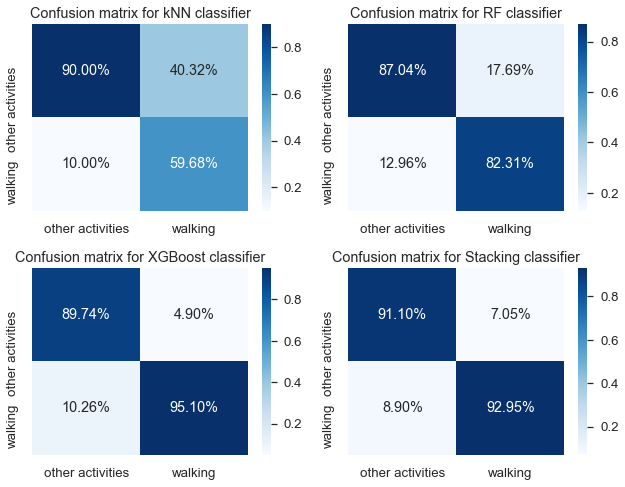

In [68]:
y_pred_ts_knn = np.load('../saved_results/pred_knn_66_33.npy', allow_pickle=True)
y_pred_ts_rf = np.load('../saved_results/pred_rf_66_33.npy', allow_pickle=True)
y_pred_ts_xgb = np.load('../saved_results/pred_xgb_66_33.npy', allow_pickle=True)
y_pred_ts_stack = np.load('../saved_results/pred_stack_66_33.npy', allow_pickle=True)
ytest = np.load('../saved_results/ytest_66_33.npy', allow_pickle=True)



cf_matrix_knn = confusion_matrix(ytest, y_pred_ts_knn)
cf_matrix_rf = confusion_matrix(ytest, y_pred_ts_rf)
cf_matrix_xgb = confusion_matrix(ytest, y_pred_ts_xgb)
cf_matrix_stack = confusion_matrix(ytest, y_pred_ts_stack)

fig, ax = plt.subplots(2, 2, figsize=(9,7))

sns.heatmap(cf_matrix_knn/cf_matrix_knn.astype(np.float).sum(axis=0), annot=True, fmt='.2%', cmap='Blues', 
            xticklabels=['other activities', 'walking'], yticklabels=['other activities', 'walking'], ax=ax[0, 0]) #np.sum(cf_matrix)
sns.heatmap(cf_matrix_rf/cf_matrix_rf.astype(np.float).sum(axis=0), annot=True, fmt='.2%', cmap='Blues', 
            xticklabels=['other activities', 'walking'], yticklabels=['other activities', 'walking'], ax=ax[0, 1]) 
sns.heatmap(cf_matrix_xgb/cf_matrix_xgb.astype(np.float).sum(axis=0), annot=True, fmt='.2%', cmap='Blues', 
            xticklabels=['other activities', 'walking'], yticklabels=['other activities', 'walking'], ax=ax[1, 0]) 
sns.heatmap(cf_matrix_stack/cf_matrix_stack.astype(np.float).sum(axis=0), annot=True, fmt='.2%', cmap='Blues', 
            xticklabels=['other activities', 'walking'], yticklabels=['other activities', 'walking'], ax=ax[1, 1]) 
ax[0, 0].set_title('Confusion matrix for kNN classifier')
ax[0, 1].set_title('Confusion matrix for RF classifier')
ax[1, 0].set_title('Confusion matrix for XGBoost classifier')
ax[1, 1].set_title('Confusion matrix for Stacking classifier')
fig.tight_layout()
sns.set(font_scale=1.2)

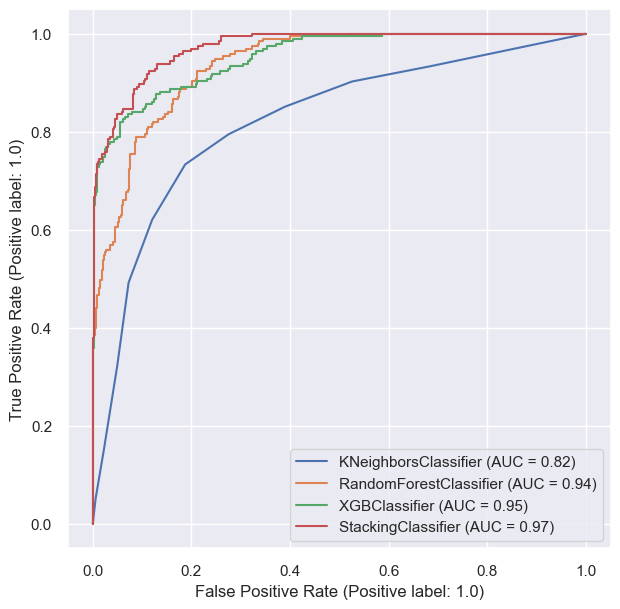

In [298]:
with open('model_knn.pkl', 'rb') as f:
    model_knn = pickle.load(f)
with open('model_rf.pkl', 'rb') as f:
    model_rf = pickle.load(f)
with open('model_xgb.pkl', 'rb') as f:
    model_xgb = pickle.load(f)
with open('model_stack.pkl', 'rb') as f:
    model_stack = pickle.load(f)


fig, ax = plt.subplots(figsize=(7, 7))
knn_disp = plot_roc_curve(model_knn, xtest, ytest, ax=ax)
rf_disp = plot_roc_curve(model_rf, xtest, ytest, ax=knn_disp.ax_)
xgb_disp = plot_roc_curve(model_xgb, xtest, ytest, ax=knn_disp.ax_)
stack_disp = plot_roc_curve(model_stack, xtest, ytest, ax=knn_disp.ax_)
sns.set(font_scale=1)